In [13]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from einops import rearrange
plt.rcParams['figure.dpi'] = 100

VoxelGridPhantom
size = tensor([0.1810, 0.2170, 0.1810])


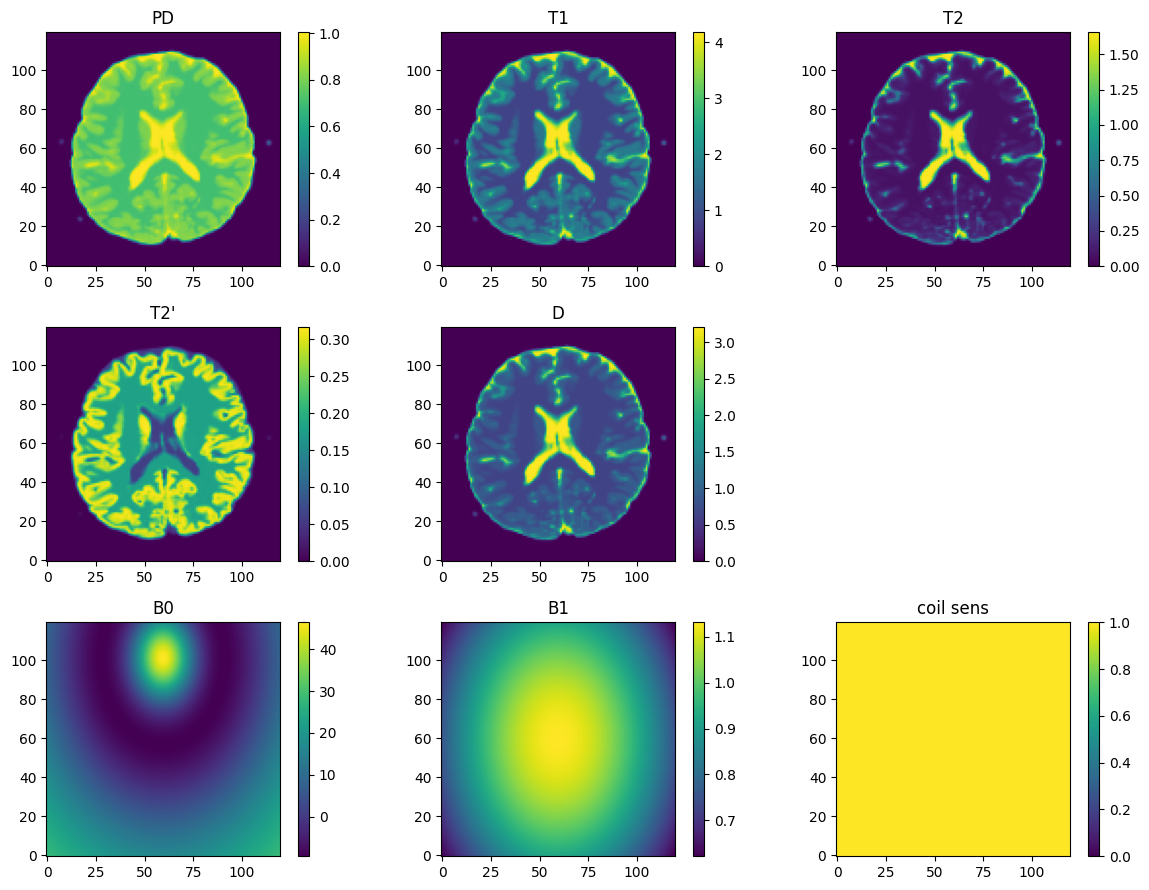

In [31]:
phantom_size = 120
phantom = mr0.VoxelGridPhantom.load("phantom/subject06_3T.npz")
phantom = phantom.interpolate(phantom_size, phantom_size, 1)
data = phantom.build()
# phantom.B0*=15
# phantom.D=torch.ones_like(phantom.D)*0
# phantom.T2dash=torch.ones_like(phantom.T2dash)*0.3
phantom.plot()

>>>> Rust - compute_graph(...) >>>
Converting Python -> Rust: 0.002111152 s
Compute Graph
Computing Graph: 0.1930232 s
Analyze Graph
Analyzing Graph: 0.00071865 s
Converting Rust -> Python: 0.28021446 s
<<<< Rust <<<<


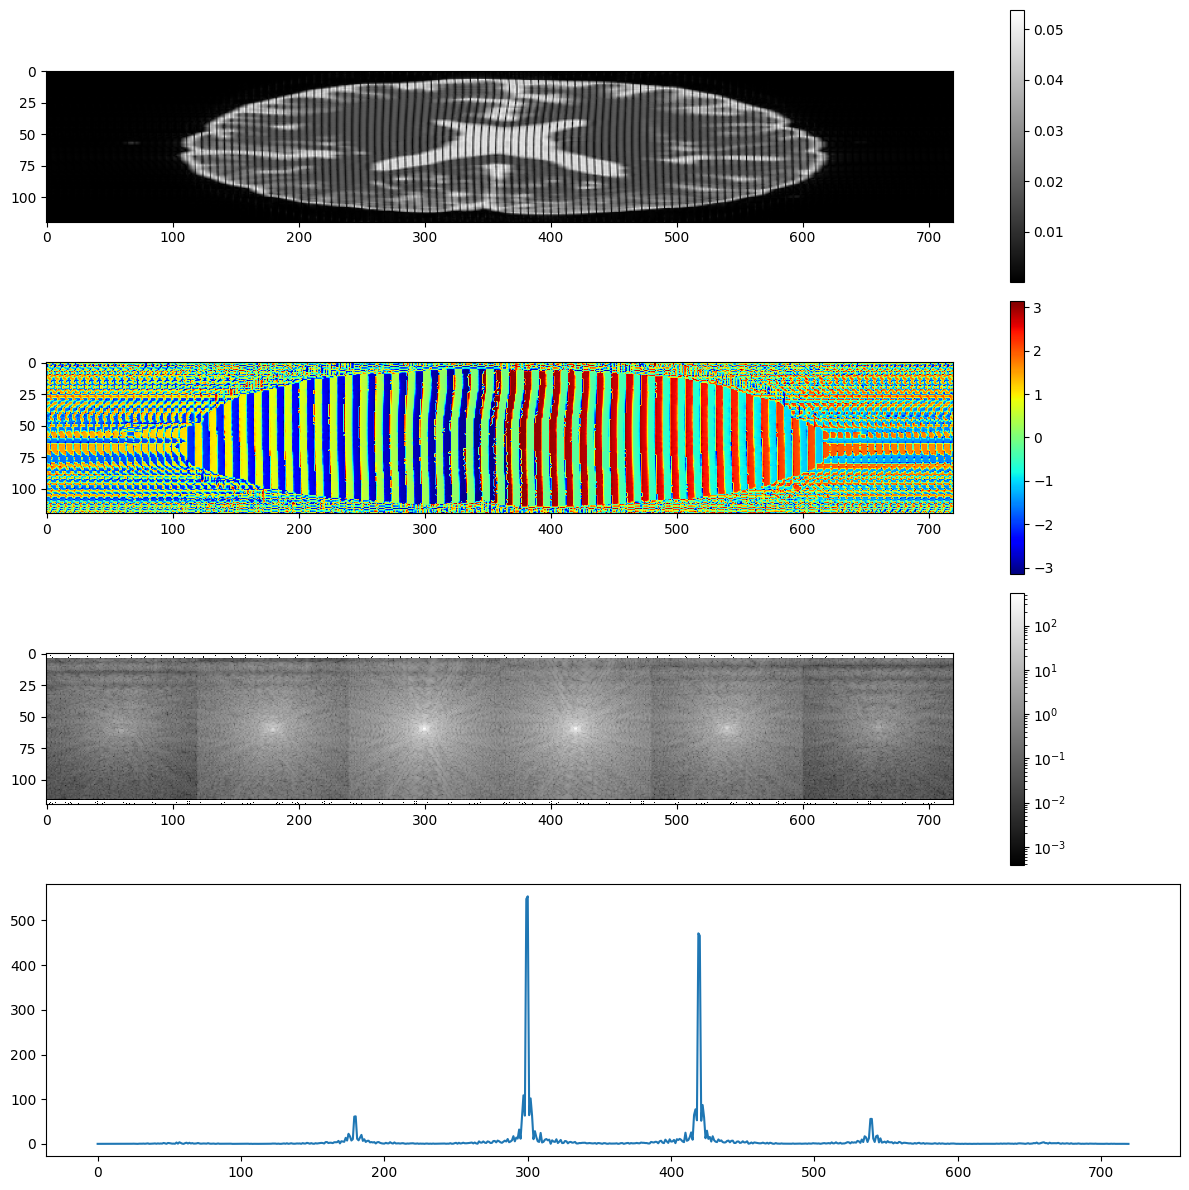

In [32]:
# seq_path = "seq/seq_p2n3.seq"
seq_path = "seq/seq_p2n3_spoiler.seq"
seq = pp.Sequence()
seq.read(seq_path)
signal, ksp = mr0.util.simulate(seq, phantom, accuracy=1e-5)

k_space = signal.reshape(phantom_size, -1)
spectrum = torch.fft.ifftshift(k_space)
space = torch.fft.ifft2(spectrum)
space = torch.fft.fftshift(space)

plt.figure(figsize=(12, 12))
plt.subplot(4,1,1)
plt.imshow(np.abs(space.numpy()), cmap="gray")
plt.colorbar()

plt.subplot(4,1,2)
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi, cmap="jet")
plt.colorbar()

plt.subplot(4,1,3)
plt.imshow(np.abs(k_space.numpy()), cmap="gray", norm=LogNorm())
plt.colorbar()

plt.subplot(4,1,4)
plt.plot(np.abs(k_space.numpy())[k_space.shape[0]//2,:])

plt.tight_layout()

torch.Size([6, 120, 120])


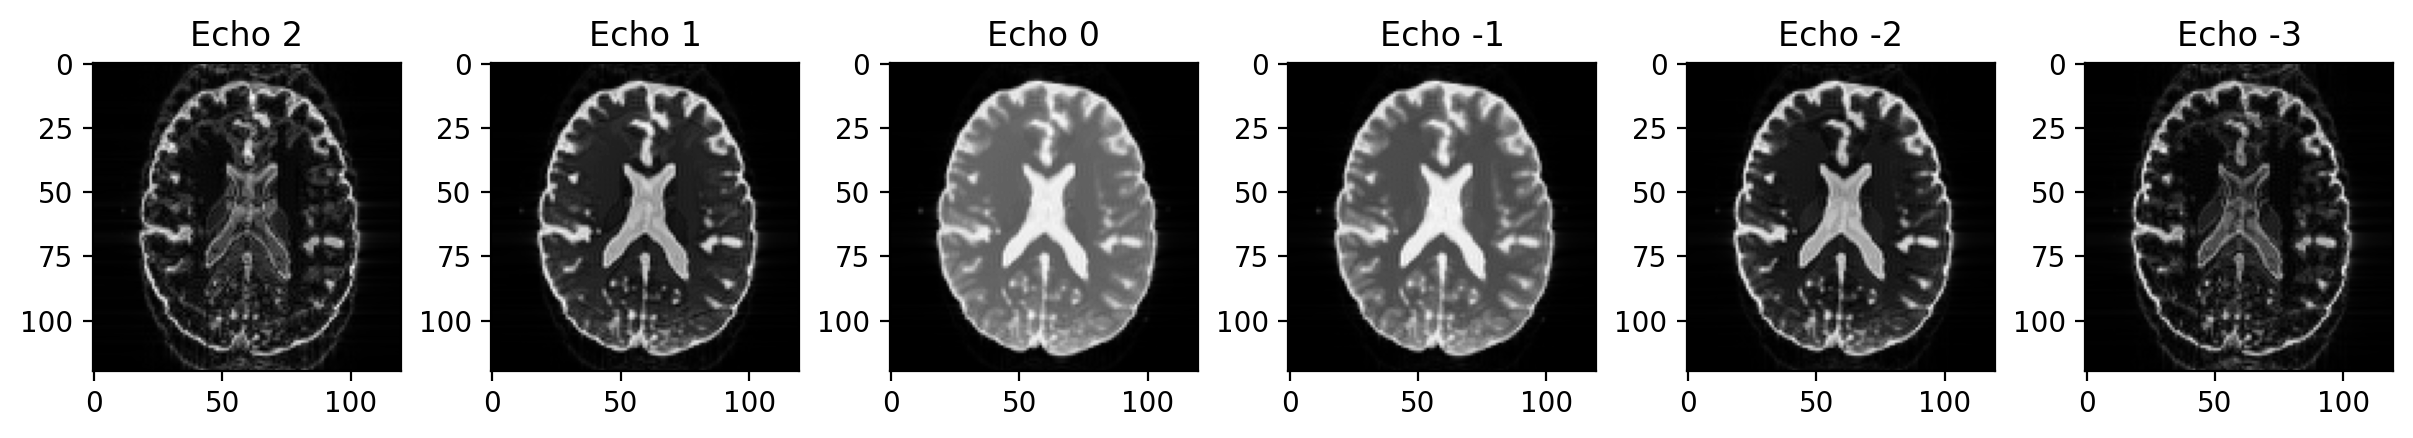

In [33]:
k_echoes = rearrange(k_space, "h (n w) -> n h w", n=6)
print(k_echoes.shape)

img_echoes = torch.fft.ifftshift(torch.fft.ifft2(torch.fft.fftshift(k_echoes, dim=(1,2)), dim=(1,2)), dim=(1,2))

plt.figure(figsize=(15, 2), dpi=200)
for idx,i in enumerate(np.linspace(2, -3 , 6,dtype=int)):
    plt.subplot(1,6,idx+1)
    plt.imshow(np.abs(img_echoes[idx].numpy()), cmap="gray")
    plt.title(f"Echo {i}")

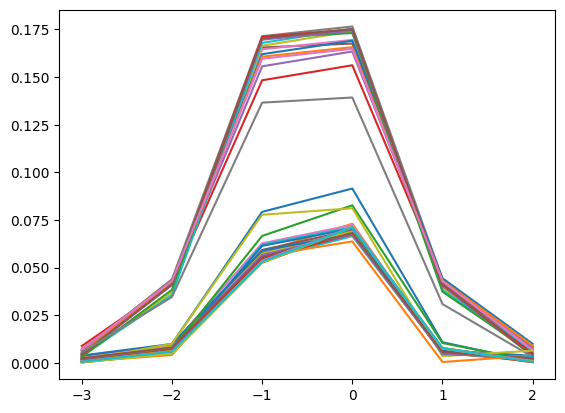

In [ ]:
n = np.linspace(2,-3,6)
plt.plot(n,torch.abs(img_echoes[:,60,40:80]))
# plt.yscale("log")

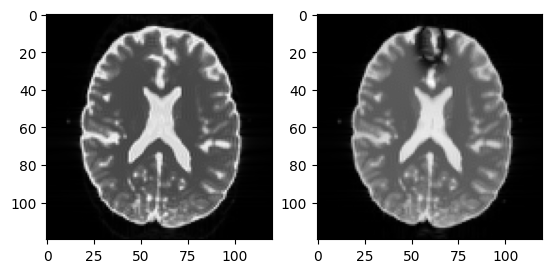

In [35]:
plt.subplot(1,2,1)
plt.imshow(torch.abs(img_echoes).sum(dim=0).numpy(), cmap="gray")
plt.subplot(1,2,2)
plt.imshow(torch.abs((img_echoes).sum(dim=0)).numpy(), cmap="gray")